In [98]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pyabf

def find_abf_files(root_dir):
    """
    Recursively search for all *.abf files under `root_dir`.
    Return a dictionary mapping the short filename (e.g., '24n15005.abf')
    -> the absolute path to that file.
    """
    abf_dict = {}
    for root, dirs, files in os.walk(root_dir):
        for fname in files:
            if fname.lower().endswith(".abf"):
                full_path = os.path.join(root, fname)
                abf_dict[fname] = full_path
    return abf_dict
def find_stim_time_digital(abf, sweep_index, dig_out_num=3):
    """
    Example: return first time where digital signal transitions from 0 to 1.
    (Adapt as needed, or skip if you have your own method.)
    """
    abf.setSweep(sweep_index)
    time_s = abf.sweepX
    digital_sig = abf.sweepD(dig_out_num)
    idxs = np.where(digital_sig > 0.5)[0]
    if len(idxs) == 0:
        return None
    return time_s[idxs[0]]


def load_all_sweeps(abf_path, stim_chan=3, domain_window=(-0.1, 0.5)):
    """
    Load all sweeps from the ABF at abf_path.
    Return a dict with:
      {
        "raw_traces": [array_of_pA_1, array_of_pA_2, ...],
        "time_axis":  array_of_time_s (common for all sweeps),
      }
    
    Steps:
      1) Load ABF
      2) For each sweep, detect stim_time (if possible). If found, slice domain [stim_time + domain_window].
         Otherwise, keep entire sweep or do a fallback domain.
      3) Baseline-subtract if desired.
    """
    if not os.path.isfile(abf_path):
        print(f"[WARNING] ABF not found: {abf_path}")
        return None

    abf = pyabf.ABF(abf_path)

    # We store one time array and a list of current arrays
    # (We’ll enforce that all sweeps have the same domain size, so we can average.)
    all_traces = []
    all_time = None

    for sweep_idx in abf.sweepList:
        time_s = abf.sweepX
        # Attempt to find stim time from digital output
        stim_time = find_stim_time_digital(abf, sweep_idx, dig_out_num=stim_chan)
        if stim_time is not None:
            t_min = stim_time + domain_window[0]
            t_max = stim_time + domain_window[1]
        else:
            # If no stim time found, fallback to the entire sweep
            t_min = time_s[0]
            t_max = time_s[-1]
        if not np.isnan(stim_time):
            baseline_start_sec = stim_time - 0.1
            baseline_end_sec   = stim_time
        else:
            # fallback if no stim
            baseline_start_sec = 1.155
            baseline_end_sec   = 1.156

        # Make a mask for [t_min, t_max]
        mask = (time_s >= t_min) & (time_s <= t_max)
        if not np.any(mask):
            # If there's no data in that window, skip
            continue

        abf.setSweep(sweep_idx, channel=0, baseline=[baseline_start_sec, baseline_end_sec])
        current_pA = abf.sweepY
        
        t_sel = time_s[mask]
        i_sel = current_pA[mask]

        # If it's the first successful sweep, store as reference
        if all_time is None:
            all_time = t_sel - t_sel[0]  # shift to 0-based time, or keep absolute
        else:
            # We must ensure we can align all sweeps in the same time array shape
            if len(t_sel) != len(all_time):
                # If different sample counts, you might do interpolation or skip
                continue

        all_traces.append(i_sel)

    if (all_time is None) or (len(all_traces) == 0):
        return None

    all_traces = np.array(all_traces)  # shape = (N_sweeps, N_points)
    return {
        "time_s": all_time,
        "raw_traces": all_traces
    }


def filename_to_path(filename, abf_root="./sorted_directory"):
    # Ensure abf_root is a Path object
    if not isinstance(abf_root, Path):
        abf_root = Path(abf_root)
    
    # 1) Dictionary of ABF files (assumes find_abf_files returns a dictionary)
    abf_dict = find_abf_files(abf_root)

    # 2) Get the ABF path
    if filename not in abf_dict:
        print(f"[ERROR] ABF file not found: {filename}")
        return
    else:
        return abf_dict[filename]

def create_ei_plots_shared_axes_from_files(
    file_pairs,  # list of tuples: (epsc_filename, ipsc_filename). Pass None if one is missing.
    abf_root=Path("./sorted_directory"),
    domain_window=(-0.1, 1),
    no_ticks=True,
    figsize_mm=(55.6, 68.3),  # figure size in millimeters (default ~2.19 x 2.69 inches)
    title_fontsize=14,
    label_fontsize=3,
    show_title=False,
    show_legend=False,
    show_epsc=True,        # controls whether to plot EPSC data
    show_ipsc=True,        # controls whether to plot IPSC data
    scale_bar_label=False,
    scale_bar_position="right_upper",
    show_mean=True,
    show_raw_epsc=False,
    show_raw_ipsc=False,
    color_epsc="blue",
    color_ipsc="red",
    stim_chan=3,           # default stimulation channel for both EPSC and IPSC data
    save_formats=["png"],  # file format(s) for saving the plot; can be a single string or list of strings
    lw_raw=0.7,            # new: line width for raw trace plots
    lw_mean=2.0,           # new: line width for mean traces
    lw_stim=1.5,           # new: line width for vertical stimulus marker
    lw_scale=2,            # new: line width for scale bar segments
    scale_ms=50e-3,        # new: horizontal scale bar length in seconds (e.g., 50e-3 s = 50 ms)
    scale_pA=50            # new: vertical scale bar height in pA
):
    """
    For each pair of ABF file names (epsc, ipsc), load the EPSC and IPSC ABF files,
    then plot them with shared X domain (time) and Y range (current).

    Plotting options (with defaults):
        abf_root="./sorted_directory",
        domain_window=(-0.1, 1),
        no_ticks=True,
        figsize_mm=(55.6, 68.3)  # figure size in millimeters (converted internally to inches)
        title_fontsize=14,
        label_fontsize=3,
        show_title=False,
        show_legend=False,
        show_epsc=True,
        show_ipsc=True,
        scale_bar_label=False,
        scale_bar_position="right_upper",
        show_mean=True,
        show_raw_epsc=False,
        show_raw_ipsc=False,
        color_epsc="blue",
        color_ipsc="red",
        stim_chan=3,
        save_formats=["png"],
        lw_raw=0.7,            # line width for raw traces
        lw_mean=2.0,           # line width for mean traces
        lw_stim=1.5,           # line width for stimulus marker
        lw_scale=2,            # line width for scale bar segments
        scale_ms=50e-3,        # horizontal scale bar length (in seconds)
        scale_pA=50            # vertical scale bar height (in pA)

    Args:
      file_pairs : list of tuples (epsc_filename, ipsc_filename). If one filename is None, it will be skipped.
      abf_root : path to the directory containing the ABF files (as a Path object).
      domain_window : tuple (start_offset, end_offset) relative to stimulus time.
      no_ticks : if True, hide axes ticks and draw an L-shaped scale bar.
      figsize_mm : size of each output figure specified in millimeters.
      title_fontsize, label_fontsize : control text sizes.
      show_title, show_legend : booleans to control title & legend display.
      show_epsc : whether to load/plot EPSC data.
      show_ipsc : whether to load/plot IPSC data.
      scale_bar_label : if True, show numeric labels for the scale bar.
      scale_bar_position : placement of the scale bar (e.g., "right_upper" or "right_middle").
      show_mean : if True, plot the mean EPSC/IPSC trace over the raw sweeps.
      show_raw_epsc : if True, plot raw sweeps for the EPSC data.
      show_raw_ipsc : if True, plot raw sweeps for the IPSC data.
      color_epsc : color for EPSC traces (both raw and mean).
      color_ipsc : color for IPSC traces (both raw and mean).
      stim_chan : stimulation channel used when loading the sweeps.
      save_formats : file format(s) in which to save the output plot.
      lw_raw : line width for raw sweep traces.
      lw_mean : line width for the averaged (mean) traces.
      lw_stim : line width for the vertical stimulus marker.
      lw_scale : line width for the scale bar segments.
      scale_ms : horizontal scale bar length in seconds.
      scale_pA : vertical scale bar height in pA.
    """
    # Ensure abf_root is a Path object
    if not isinstance(abf_root, Path):
        abf_root = Path(abf_root)

    # Convert figsize from millimeters to inches (1 inch = 25.4 mm)
    figsize_inch = (figsize_mm[0] / 25.4, figsize_mm[1] / 25.4)

    # Make sure save_formats is a list, even if a single string is provided
    if isinstance(save_formats, str):
        save_formats = [save_formats]

    all_data = []  # will hold tuples (epsc_filename, ipsc_filename, data_epsc, data_ipsc)
    global_min = None
    global_max = None
    global_tmax = 0.0   # track largest time across all files

    # ─────────────────────────────────────────────────────────
    # 1) First pass: load data for all file pairs and find global min/max and global_tmax
    # ─────────────────────────────────────────────────────────
    for epsc_filename, ipsc_filename in file_pairs:
        epsc_abfpath = filename_to_path(epsc_filename, abf_root) if epsc_filename and show_epsc else None
        ipsc_abfpath = filename_to_path(ipsc_filename, abf_root) if ipsc_filename and show_ipsc else None

        data_epsc = load_all_sweeps(epsc_abfpath, stim_chan=stim_chan, domain_window=domain_window) if epsc_abfpath else None
        data_ipsc = load_all_sweeps(ipsc_abfpath, stim_chan=stim_chan, domain_window=domain_window) if ipsc_abfpath else None

        all_data.append((epsc_filename, ipsc_filename, data_epsc, data_ipsc))

        local_vals = []
        if data_epsc is not None:
            local_vals.append(data_epsc["raw_traces"].min())
            local_vals.append(data_epsc["raw_traces"].max())
            global_tmax = max(global_tmax, data_epsc["time_s"][-1])
        if data_ipsc is not None:
            local_vals.append(data_ipsc["raw_traces"].min())
            local_vals.append(data_ipsc["raw_traces"].max())
            global_tmax = max(global_tmax, data_ipsc["time_s"][-1])
        if local_vals:
            local_min = min(local_vals)
            local_max = max(local_vals)
            if global_min is None or local_min < global_min:
                global_min = local_min
            if global_max is None or local_max > global_max:
                global_max = local_max

    if global_min is None or global_max is None:
        print("[INFO] No valid data found in any file pair. Aborting.")
        return

    # Add some padding to Y range
    y_range = global_max - global_min
    y_min = global_min - 0.1 * y_range
    y_max = global_max + 0.1 * y_range

    # ─────────────────────────────────────────────────────────
    # 2) Second pass: plot each file pair's data using the shared domain & range
    # ─────────────────────────────────────────────────────────
    for epsc_filename, ipsc_filename, data_epsc, data_ipsc in all_data:
        if data_epsc is None and data_ipsc is None:
            print(f"[WARNING] No valid EPSC or IPSC data for files: {epsc_filename}, {ipsc_filename}. Skipping plot.")
            continue

        fig, ax = plt.subplots(figsize=figsize_inch)

        # Plot EPSC data
        if show_epsc and data_epsc is not None:
            t_epsc = data_epsc["time_s"]
            arr_epsc = data_epsc["raw_traces"]
            if show_raw_epsc:
                for trace in arr_epsc:
                    ax.plot(t_epsc, trace, color=color_epsc, alpha=0.1, lw=lw_raw)
            if show_mean:
                mean_epsc = arr_epsc.mean(axis=0)
                ax.plot(t_epsc, mean_epsc, color=color_epsc, lw=lw_mean, label="Mean EPSC")

        # Plot IPSC data
        if show_ipsc and data_ipsc is not None:
            t_ipsc = data_ipsc["time_s"]
            arr_ipsc = data_ipsc["raw_traces"]
            if show_raw_ipsc:
                for trace in arr_ipsc:
                    ax.plot(t_ipsc, trace, color=color_ipsc, alpha=0.1, lw=lw_raw)
            if show_mean:
                mean_ipsc = arr_ipsc.mean(axis=0)
                ax.plot(t_ipsc, mean_ipsc, color=color_ipsc, lw=lw_mean, label="Mean IPSC")

        # Stimulus marker (assuming stimulus time is at -domain_window[0])
        ax.axvline(
            x=-domain_window[0],
            color="blue",
            lw=lw_stim,
            alpha=0.6,
            label="Stim",
            ymin=0.9,
            ymax=1.0
        )

        # Set global x (time) domain and y (current) range
        ax.set_xlim(0, global_tmax)
        ax.set_ylim(y_min, y_max)

        if show_legend:
            ax.legend(fontsize=label_fontsize)

        if no_ticks:
            # Remove spines and ticks
            for spine in ["top", "right", "left", "bottom"]:
                ax.spines[spine].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # Determine scale bar position and draw scale bar segments
            x_min_plot, x_max_plot = ax.get_xlim()
            y_min_plot, y_max_plot = ax.get_ylim()
            x_range = x_max_plot - x_min_plot
            y_rng = y_max_plot - y_min_plot

            if scale_bar_position == "right_upper":
                x_ref = x_max_plot - 0.05 * x_range - scale_ms
                y_ref = y_max_plot - 0.15 * y_rng
            elif scale_bar_position == "right_middle":
                x_ref = x_max_plot - 0.05 * x_range - scale_ms
                y_ref = y_min_plot + 0.45 * y_rng
            else:
                x_ref = x_max_plot - 0.05 * x_range - scale_ms
                y_ref = y_min_plot + 0.1 * y_rng

            # Horizontal scale bar segment
            ax.plot(
                [x_ref, x_ref + scale_ms],
                [y_ref, y_ref],
                color='k',
                lw=lw_scale
            )
            # Vertical scale bar segment
            ax.plot(
                [x_ref, x_ref],
                [y_ref, y_ref + scale_pA],
                color='k',
                lw=lw_scale
            )
            # Optionally add numeric labels to scale bar (disabled by default)
            if scale_bar_label:
                ax.text(
                    x_ref + scale_ms/2,
                    y_ref - 0.05 * scale_pA,
                    f"{int(scale_ms*1000)} ms",
                    ha="center",
                    va="top",
                    fontsize=label_fontsize
                )
                ax.text(
                    x_ref - 0.05 * scale_ms,
                    y_ref + scale_pA/2,
                    f"{scale_pA} pA",
                    ha="right",
                    va="center",
                    rotation=90,
                    fontsize=label_fontsize
                )
        else:
            ax.tick_params(axis='both', which='both', length=3, labelsize=label_fontsize)
            ax.set_xlabel("Time (s)", fontsize=label_fontsize)
            ax.set_ylabel("Current (pA)", fontsize=label_fontsize)

        if show_title:
            title_str = f"EPSC: {Path(epsc_filename).name if epsc_filename else 'NA'} | IPSC: {Path(ipsc_filename).name if ipsc_filename else 'NA'}"
            ax.set_title(title_str, fontsize=title_fontsize)

        plt.tight_layout()

        # Build the output filename from the provided file names.
        base_epsc = Path(epsc_filename).stem if epsc_filename else "NA"
        base_ipsc = Path(ipsc_filename).stem if ipsc_filename else "NA"
        save_dir = abf_root / "EIplots"
        save_dir.mkdir(parents=True, exist_ok=True)

        # Save the figure in each format specified in save_formats
        for fmt in save_formats:
            out_name = f"eiplot_{base_epsc}_{base_ipsc}.{fmt}"
            savepath = save_dir / out_name
            plt.savefig(savepath, dpi=150, transparent=True)
            print(f"Saved: {out_name}")

        plt.show()

    print("Done creating E-I plots with shared domain/range.")





In [165]:
file_pairs_ACC_42_016 = [
    ("25221026.abf", "25221020.abf"),
    ("25215024.abf", "25215028.abf"),
    ("25221031.abf", "25221034.abf"),
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_ACC_42_032 = [
    ("25221015.abf", "25221017.abf"),
    ("25215005.abf", "25215013.abf"),
    ("25221042.abf", "25221047.abf"),
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_RSC_42_010 = [
    ("25220044.abf", "25220037.abf"),
    ("25214075.abf", "25214072.abf"),
    ("25220020.abf", "25220023.abf"),
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_RSC_42_016 = [
    ("25220064.abf", "25220066.abf"),
    ("25206060.abf", "25206065.abf"),
    ("25214003.abf", "25214006.abf"),
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_GtCCR4_large = [
    ("31115102.abf", "31115100.abf"),
    ("23n25104.abf", "23n25097.abf")
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_monoIPSC_ACC = [
    ("24n09044.abf", "24n09046.abf"),
    ("24n09052.abf", "24n09054.abf"),
    (None, "24n09062.abf")
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_monoIPSC_RSC = [
    ("24n14022.abf", "24n14020.abf"),
    ("24n14028.abf", "24n14026.abf"),
    (None, "24n14037.abf")
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_monoIPSC_Both = [
    ("24n09044.abf", "24n09046.abf"),
    ("24n09052.abf", "24n09054.abf"),
    (None, "24n09062.abf"),
    ("24n14022.abf", "24n14020.abf"),
    ("24n14028.abf", "24n14026.abf"),
    (None, "24n14037.abf")
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]

file_EPSC_ACCRSC_42_016 = [
    ("25221020.abf", None), # ACC-ChR2 250221_ID37 Slice1 Cell5 -2.8
    ("25215035.abf", None), # ACC-ChR2 250215_ID36 Slice1 Cell4 -3.9
    ("25215055.abf", None), # ACC-ChR2 250215_ID36 Slice2 Cell3 -4.6
    ("25220064.abf", None), # RSC-ChR2 250220_ID35 Slice3 Cell1 -2.3
    ("25206060.abf", None), # RSC-ChR2 250206_ID32 Slice3 Cell2 -3.4
    ("25214003.abf", None) # RSC-ChR2 250214_ID31 Slice1 Cell1 -4.1
]

file_pairs_ACC_42_016 = [
    ("25221026.abf", "25221020.abf"),
    ("25215024.abf", "25215028.abf"),
    ("25221031.abf", "25221034.abf"),
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]
file_pairs_RSC_42_016 = [
    ("25220064.abf", "25220066.abf"),
    ("25206060.abf", "25206065.abf"),
    ("25214003.abf", "25214006.abf"),
    # If one channel is missing, use None:
    #("EPSC_file3.abf", None)
]

file_IPSC_ACCRSC_42_016 = [
    ("25221026.abf", None), # ACC-ChR2 250221_ID37 Slice1 Cell5 -2.8
    ("25215028.abf", None), # ACC-ChR2 250215_ID36 Slice1 Cell4 -3.9
    ("25221034.abf", None), # ACC-ChR2 250215_ID36 Slice2 Cell3 -4.6
    ("25220056.abf", None), # RSC-ChR2 250220_ID35 Slice3 Cell1 -2.3
    ("25206079.abf", None), # RSC-ChR2 250206_ID32 Slice3 Cell2 -3.4
    ("25214006.abf", None) # RSC-ChR2 250214_ID31 Slice1 Cell1 -4.1
]
file_EPSC_RSC_42_010 = [
    ("25214018.abf", None), # RSC-ChR2 250214_ID31 Slice3 Cell1 -4.1
    ("25214058.abf", None), # RSC-ChR2 250214_ID31 Slice3 Cell2 -3.5
    ("25220061.abf", None), # RSC-ChR2 250220_ID35 Slice3 Cell3 -2.3
]
file_EPSC_ACC_42_016= [
    ("25221001.abf", None), # ACC-ChR2 250221_ID37 Slice1 Cell4 -2.8
    ("25215035.abf", None), # ACC-ChR2 250215_ID36 Slice1 Cell4 -3.9
    ("25221031.abf", None), # ACC-ChR2 250221_ID37 Slice2 Cell1 -4.6
]


file_pairs_ACCRSC_weakstrong = [
    ("24o19025.abf", "24o19027.abf"), # ACC-ChR2 241019_ID159 Slice3 Cell1 weak anterior
    ("25206036.abf", "25206046.abf"), # RSC-ChR2 250206_ID32 Slice2 Cell2 weak posterior
    ("24o19026.abf", "24o19028.abf"), # ACC-ChR2 241019_ID159 Slice3 Cell1 strong anterior
    ("25206040.abf", "25206043.abf"), # RSC-ChR2 250206_ID32 Slice2 Cell2 strong posterior
]

file_ACCRSC_weakEPSC = [
    ("24o19025.abf", None),
    ("24d10042.abf", None)
]

filenames_ACC_EPSC_ID36_Cell3 = [
    ("25215055.abf", None),
    ("25215064.abf", None),
    ("25215062.abf", None),
]

filenames_RSC_EPSC_ID35_Cell3 = [
    ("25220050.abf", None),
    ("25220052.abf", None),
    ("25220054.abf", None),
    ("25206002.abf", None),
    ("25206009.abf", None),
    ("25206011.abf", None),
]

check = [("25221021.abf", None)]

light_orange = "#ff4b00"
light_green = "#03af7a"

Saved: eiplot_25221026_NA.svg


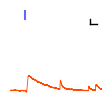

Saved: eiplot_25215028_NA.svg


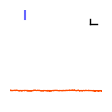

Saved: eiplot_25221034_NA.svg


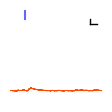

Saved: eiplot_25220056_NA.svg


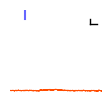

Saved: eiplot_25206079_NA.svg


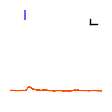

Saved: eiplot_25214006_NA.svg


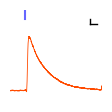

Done creating E-I plots with shared domain/range.


In [169]:
create_ei_plots_shared_axes_from_files(
    file_IPSC_ACCRSC_42_016, #使うtuple選ぶ
    #abf_root="./sorted_directory",
    abf_root="./",
    domain_window=(-0.1, 0.5),
    no_ticks=True,
    figsize_mm=(31, ),  # size of each output figure in millimeters (default ~2.19 x 2.69 inches)
    title_fontsize=14,
    label_fontsize=3,
    show_title=False,
    show_legend=False,
    show_epsc=True,
    show_ipsc=True,
    scale_bar_label=False,
    scale_bar_position="right_upper",
    show_mean=True,
    show_raw_epsc=False,
    show_raw_ipsc=False,
    color_epsc=light_orange,
    color_ipsc=light_orange,
    stim_chan=3,
    save_formats=["svg"],
    lw_raw=0.1,            # new: line width for raw trace plots
    lw_mean=0.6,           # new: line width for mean traces
    lw_stim=1.5,           # new: line width for vertical stimulus marker
    lw_scale=1,            # new: line width for scale bar segments
    scale_ms=50e-3,        # new: horizontal scale bar length in seconds (e.g., 50e-3 s = 50 ms)
    scale_pA=50            # new: vertical scale bar height in pA
)